In [2]:
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import denseQubits as dq
import exact_jwt
import stabilizers as stab
import qubitNetworks as beeky
from itertools import product
import autoray
import scipy.sparse as sparse
import functools
import assorted_conts as ac
import networkx as nx

from quimb.tensor.tensor_core import tags_to_oset as tto

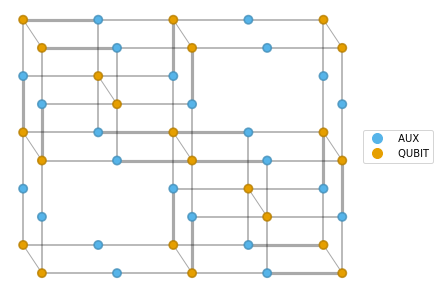

In [49]:
reload(beeky)
psi = beeky.QubitEncodeVector.rand(3,3)
psi.setup_bmps_contraction_()
norm, bra, ket = psi.make_norm(return_all=True)
# norm.rotate_face_qubits_(layer_tag='BRA')
# norm.rotate_face_qubits_(layer_tag='KET')
# norm.setup_bmps_contraction_(layer_tags=('BRA','KET'))
# norm.flatten_()
# norm.contract_boundary(sequence='b')
# norm.contract_boundary(sequence='t',layer_tags=('BRA','KET'))
norm.graph_layers(color=['AUX', 'QUBIT'])

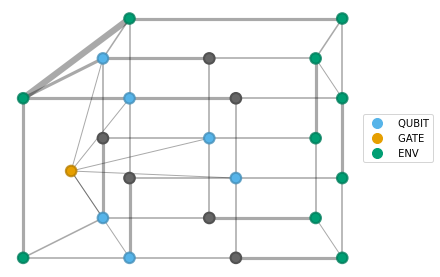

In [35]:
reload(beeky)
SimHam = beeky.SpinlessSimHam(3,3)
where_gate = (4,7,10)
# which_mpo = mpoham.get_term_at(*where_gate)

which_gate = SimHam.get_term_at(*where_gate)

psi = beeky.QubitEncodeVector.rand(3,3)
psi.setup_bmps_contraction_()
norm, bra, ket = psi.make_norm(return_all=True)

plaq_info = ((2,2), (3,2))
plaq_envs = norm.compute_plaquette_environments(x_bsz=3, y_bsz=2, first_contract='rows', layer_tags=('BRA','KET'))

plaq_tags = psi.plaquette_at(xy=plaq_info[0], bsz=plaq_info[1], get='tags')
env = plaq_envs[plaq_info]
env.add_tag('ENV')

ket_local = ket.select_any(plaq_tags).view_like_(psi)
bra_and_env = bra.select_any(plaq_tags) | env

# composite = (ket_local.apply_mpo(mpo=which_mpo, where=where_gate, contract=False) | bra_and_env).view_like_(psi)
composite = (ket_local.apply_gate(which_gate, where_gate, contract=False) | bra_and_env).view_like(psi)

composite.graph(layer_tags=('BRA','KET'),color=['QUBIT', 'GATE', 'ENV'])



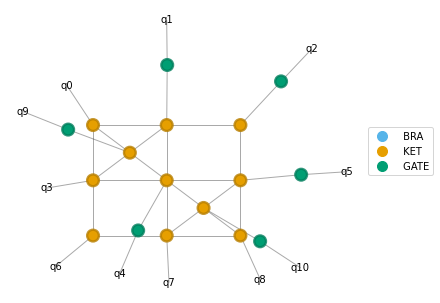

In [64]:
reload(beeky)
qlat = dq.QubitLattice(3,3)
hstab = beeky.HamStab(qlat)
stab_term = list(hstab.gen_ham_stabilizer_lists())[0]

psish = beeky.QubitEncodeVector.rand(Lx=3,Ly=3, bond_dim=2)
for k in range(6):
    qubit = stab_term[0][k]
    gate = stab_term[1][k]
    psish.apply_gate_(G=gate, where=qubit, contract=False)
psish.add_tag('KET')
psish.graph(color=['BRA','KET','GATE'])
# psish.setup_bmps_contraction_()
# norm = psish.make_norm()
# norm.graph_layers(color=['BRA','KET','GATE'])
# norm.graph()

In [23]:
import re
grex = re.compile(r'S\d,\d')
grex.match('S2,4')

<re.Match object; span=(0, 4), match='S2,4'>

In [40]:
reload(beeky)
reload(dq)
# from collections import defaultdict

LX, LY = 3, 3
T_PARAM, V_PARAM, MU_PARAM = (1, 0.2, 0.5)
D_PEPS = 2

qlat = dq.SpinlessHub(Lx=LX, Ly=LY)
mpoHam = beeky.MPOSpinlessHam(qlat, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
HubHam = beeky.SpinlessSimHam(Lx=LX, Ly=LY, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)

qubit_terms = dict(HubHam.gen_ham_terms())

horizontal_terms = dict(HubHam.gen_horizontal_ham_terms())

vertical_terms = dict(HubHam.gen_vertical_ham_terms())

qvec = beeky.QubitEncodeVector.rand(LX, LY, bond_dim=D_PEPS)


# energies = dict()
# exact_energies = dict()

E_exact = qvec.compute_ham_expec(HubHam) 
print(E_exact)
exact_energies[D_PEPS] = E_exact
print(qvec.compute_mpo_ham_expec(mpoHam))


(-2.1010858875052287+3.3801499277073573e-18j)
(-2.101085887505229+1.2321825608561122e-17j)


In [48]:
qtest = qvec.copy()
qtest.setup_bmps_contraction_()
qtest.compute_local_expectation(qubit_terms, normalized=True)

(-2.1010858875052305-4.204967181884625e-16j)

In [41]:
qtest = qvec.copy()
qtest.setup_bmps_contraction_()

for chi in range(3, 15):
    
    # if (chi, D_PEPS) not in energies:

    he = qtest.compute_local_expectation(horizontal_terms, normalized=True, max_bond=chi)

    ve = qtest.compute_local_expectation(vertical_terms, normalized=True, max_bond=chi)

    energies[chi, D_PEPS] = he + ve



In [43]:
energies

{(3, 2): (-1.9694888744668506-0.011316018909946263j),
 (4, 2): (-1.9396208002128636-0.001784042420591683j),
 (5, 2): (-1.9713408589466188-0.005811321491271987j),
 (6, 2): (-1.9634264465945277-0.0010458540750092878j),
 (7, 2): (-1.9787948843321914-0.0015940237755269406j),
 (8, 2): (-2.073940090347434-0.0005825715970991354j),
 (9, 2): (-2.1173974391199053+0.0009279903930809265j),
 (10, 2): (-2.112612371874821+0.000649405579558052j),
 (11, 2): (-2.100409948844652+0.0003450767768908861j),
 (12, 2): (-2.1058698829060836-0.00019273938788372952j),
 (13, 2): (-2.108282786724381-6.516201240823579e-05j),
 (14, 2): (-2.1138131193837264+9.03775846715843e-05j)}

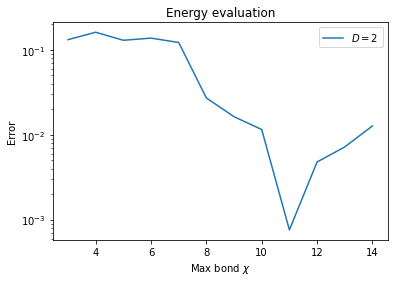

In [42]:
from collections import defaultdict
diffs = defaultdict(list)
chis = defaultdict(list)

for k, v in energies.items():
    D = k[1]
    diffs[D].append(abs(v - exact_energies[D]))
    chis[D].append(k[0])

for d in [2]:
    plt.semilogy(chis[d], diffs[d], label=f'$D={d}$')
plt.xlabel(r'Max bond $\chi$')
plt.ylabel(r'Error')
plt.title(r'Energy evaluation')
plt.legend()
